In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant
from myplot import geo_precentage, roughness_simulation

# Load data

In [2]:
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmills = pd.read_csv("./data/windmill_cleaned.csv", dtype=dtype)
# dfAgg = pd.read_parquet("./data/dfAgg.parquet")[["GSRN", "Placement", "ws10", "ws100"]]

In [3]:
len(windmills)

3576

In [4]:
windmills["Slope"] = round(windmills["Slope"], 0)
windmills["Aspect"] = round(windmills["Aspect"], 0)

In [5]:
windmill_SL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="W"]
windmill_SH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="W"]
windmill_PL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="P"]
windmill_PH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="P"]

In [6]:
print(len(windmill_SL))
print(len(windmill_SH))
print(len(windmill_PL))
print(len(windmill_PH))

3049
16
229
13


# The proportion of windmills under geo information
Roughness, Slope, Aspect

In [7]:
def geo_table(geofeature, percentage=True, sumed=False):
    type_place = {"PH" : windmill_PH ,"SH": windmill_SH, "PL":windmill_PL, "SL":windmill_SL}
    rt = pd.DataFrame(np.unique(windmills[geofeature]), columns=[geofeature]) 
    geo_count = lambda df, name: df.groupby(geofeature, as_index=False)["GSRN"].count().rename({"GSRN":name}, axis=1)
    for n, df in type_place.items():
        tmp = geo_count(df, n)
        tmp[n] = round(tmp[n] / len(df) * 100, 2) if percentage else tmp[n]
        rt = pd.merge(tmp, rt, on=geofeature, how="right")
    rt = rt.fillna(0)
    rt = rt.sort_values([geofeature]).reset_index(drop=True)

    cols = [x for x in rt.columns if x != geofeature]
    rt = rt.T
    headers = rt.iloc[0]
    rt  = pd.DataFrame(rt.values[1:], columns=headers)
    rt["type_place"] = cols
    rt = rt.set_index("type_place")
    
    if sumed:
        rt.loc[:,"sum"] = rt.sum(axis=1)
        rt.loc['sum',:]= rt.sum(axis=0)

    rt = rt if percentage else rt.astype(int)

    return rt

In [8]:
rn_count = geo_table("Roughness", False, True)
rn_count

Roughness,1e-06,0.0003,0.0005,0.005,0.03,0.05,0.1,0.3,0.5,0.6,sum
type_place,,,,,,,,,,,
SL,14,4,7,2836,22,6,31,89,10,30,3049
PL,2,0,1,212,2,0,5,5,1,1,229
SH,14,0,0,0,0,0,2,0,0,0,16
PH,13,0,0,0,0,0,0,0,0,0,13
sum,43,4,8,3048,24,6,38,94,11,31,3307


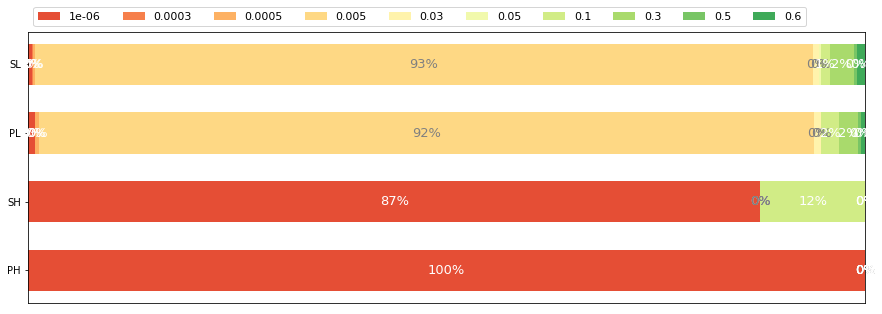

In [9]:
rn_count = geo_table("Roughness")
geo_precentage(rn_count, rn_count.columns, path=constant.plot_path+"geoanalysis/geo_precentage_roughness.png")

In [10]:
slope_count = geo_table("Slope", False, True)
slope_count

Slope,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,15.0,sum
type_place,,,,,,,,,,,,,,,,
SL,1221,549,381,627,125,69,42,10,15,5,1,1,1,1,1,3049
PL,98,46,24,39,6,10,4,0,1,1,0,0,0,0,0,229
SH,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16
PH,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
sum,1347,595,406,666,131,79,46,10,16,6,1,1,1,1,1,3307


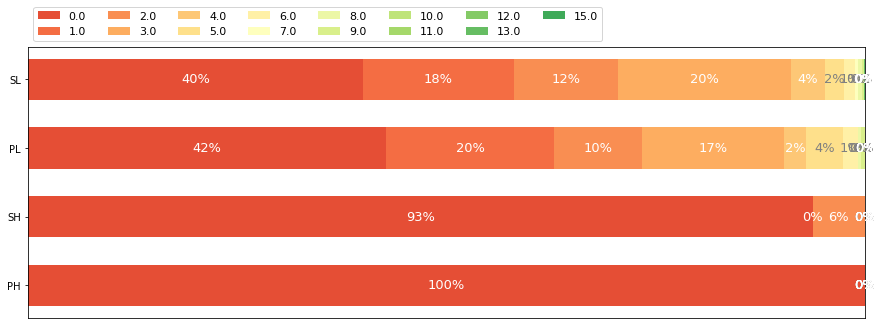

In [11]:
slope_count = geo_table("Slope")
geo_precentage(slope_count, slope_count.columns, path=constant.plot_path+"geoanalysis/geo_precentage_slope.png")

In [12]:
aspect_count = geo_table("Aspect", False, True)
# cols = [x for x in aspect_count.columns if x not in [-1.0, 0.0]]
# aspect_count["others"] = aspect_count.apply(lambda x: sum(x[cols]), axis=1)

In [13]:
aspect_count

Aspect,-1.0,-0.0,1.0,2.0,3.0,4.0,5.0,6.0,sum
type_place,,,,,,,,,
SL,2,1408,242,314,269,336,390,88,3049
PL,1,109,11,30,19,22,34,3,229
SH,11,4,0,0,0,0,0,1,16
PH,10,3,0,0,0,0,0,0,13
sum,24,1524,253,344,288,358,424,92,3307


In [14]:
aspect_count

Aspect,-1.0,-0.0,1.0,2.0,3.0,4.0,5.0,6.0,sum
type_place,,,,,,,,,
SL,2,1408,242,314,269,336,390,88,3049
PL,1,109,11,30,19,22,34,3,229
SH,11,4,0,0,0,0,0,1,16
PH,10,3,0,0,0,0,0,0,13
sum,24,1524,253,344,288,358,424,92,3307


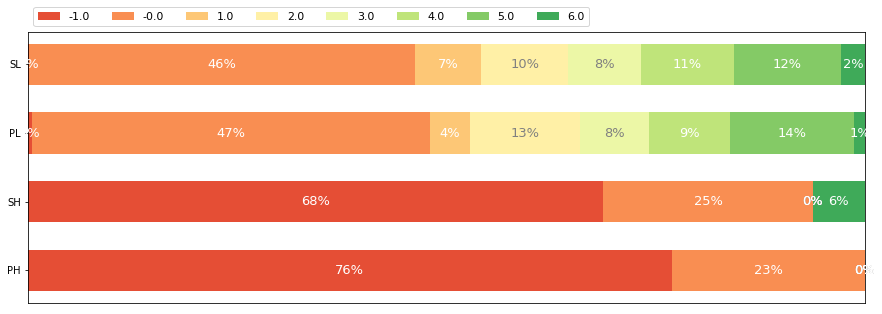

In [15]:
aspect_count = geo_table("Aspect")
geo_precentage(aspect_count, aspect_count.columns, path=constant.plot_path+"geoanalysis/geo_precentage_aspect.png")

## Geo varians Example

In [17]:
from sklearn.cluster import KMeans
from tools import normalize_zcenter

In [18]:
windmill_SL.columns

Index(['GSRN', 'Turbine_type', 'Parent_GSRN', 'BBR_municipal', 'Placement',
       'UTM_x', 'UTM_y', 'Capacity_kw', 'Rotor_diameter', 'Navhub_height',
       'In_service', 'grid', 'Aspect', 'Slope', 'Elevation', 'Roughness',
       'max_VAERDI'],
      dtype='object')

In [19]:
cols = ['Aspect', 'Slope', 'Roughness']

In [28]:
windmill_SL[cols] = normalize_zcenter(windmill_SL[cols])
windmill_SL['cls'] = KMeans().fit_predict(windmill_SL[cols])
windmill_SL.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,390
1,1,1226
2,2,84
3,3,489
4,4,389
5,5,40
6,6,69
7,7,362


In [29]:
windmill_SH[cols] = normalize_zcenter(windmill_SH[cols])
windmill_SH['cls'] = KMeans().fit_predict(windmill_SH[cols])
windmill_SH.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,11
1,1,1
2,2,1
3,5,3


In [30]:
windmill_PL[cols] = normalize_zcenter(windmill_PL[cols])
windmill_PL['cls'] = KMeans().fit_predict(windmill_PL[cols])
windmill_PL.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,98
1,1,30
2,2,2
3,3,14
4,4,30
5,5,5
6,6,28
7,7,22


In [31]:
windmill_PH[cols] = normalize_zcenter(windmill_PH[cols])
windmill_PH[cols] = windmill_PH[cols].fillna(0)
windmill_PH['cls'] = KMeans().fit_predict(windmill_PH[cols])
windmill_PH.groupby("cls", as_index=False)["GSRN"].count()

,cls,GSRN
0,0,10
1,1,3


In [25]:
SL_plt = windmill_SL[windmill_SL['cls']==0].groupby("max_VAERDI", as_index=False)["GSRN"].count()
SH_plt = windmill_SH[windmill_SH['cls']==0].groupby("max_VAERDI", as_index=False)["GSRN"].count()
PL_plt = windmill_PL[windmill_PL['cls']==1].groupby("max_VAERDI", as_index=False)["GSRN"].count()
PH_plt = windmill_PH[windmill_PH['cls']==1].groupby("max_VAERDI", as_index=False)["GSRN"].count()

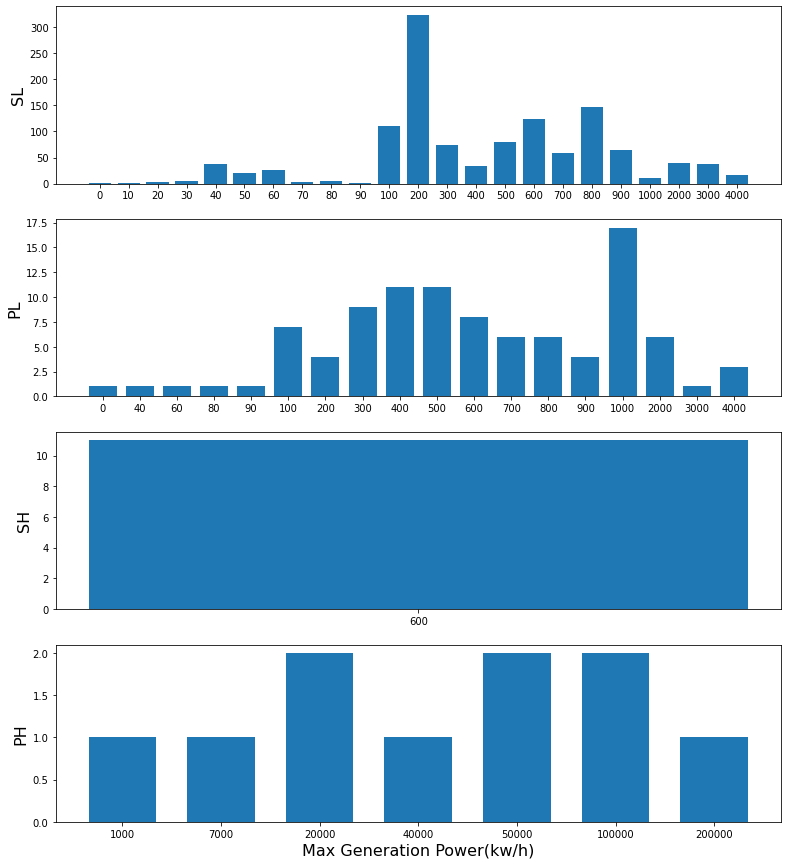

In [26]:
fig, ax = plt.subplots(4, 1, figsize=(13,15))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)

names = ["SL", "PL", "SH", "PH"]
for i, df_plt in enumerate([SL_plt, PL_plt, SH_plt, PH_plt]):
    x = np.linspace(0, len(df_plt), len(df_plt))
    y = df_plt["GSRN"]
    ax[i].bar(x, y, 0.8)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(df_plt["max_VAERDI"].astype(int))
    ax[i].set_ylabel(names[i])

# plt.ylabel("Count of Windmills")
plt.xlabel("Max Generation Power(kw/h)")
plt.show()

# A simulation of wind speed interpolation with various roughness length

Wind Speed 10m: 5 m/s  
Roughness range: \[0.000001, 0.0003, 0.0005, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6\]  
Interpolated height range: \[0,100\] m

In [2]:
from tools import pow_law, log_law, rn_exponent

In [3]:
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmills = pd.read_csv("./data/windmill_cleaned.csv", dtype=dtype)
ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws10_path)

In [4]:
get_ws_h_emrn = lambda h, rn : round(pow_law(ws_ass10, 10, h, rn_exponent(rn)), 5)
get_ws_h_smrn = lambda h, rn : round(log_law(ws_ass10, 10, h, rn), 5)

In [5]:
np.unique(windmills["Roughness"])

array([1.e-06, 3.e-04, 5.e-04, 5.e-03, 3.e-02, 5.e-02, 1.e-01, 3.e-01,
       5.e-01, 6.e-01])

In [6]:
ws_ass10 = 5
rn_range = [0.000001, 0.0003, 0.0005, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6]
h_range = np.linspace(0.1,100,201)

In [7]:
ls_emrn = pd.DataFrame([], columns=h_range, index = rn_range)
ls_smrn = pd.DataFrame([], columns=h_range, index = rn_range)
# ls_comrn = pd.DataFrame([], columns=h_range, index = rn_range)

In [8]:
for rn in rn_range:
    for h in h_range:
        ls_emrn.loc[rn][h] = get_ws_h_emrn(h, rn) 
        ls_smrn.loc[rn][h] = get_ws_h_smrn(h, rn)
        # ls_comrn.loc[rn][h] = get_ws_h_rn(h, rn) if rn >= 0.001 else get_ws_h_smrn(h, rn)

In [9]:
ls_emrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,1.65566,2.54472,2.94313,3.22004,3.43719,3.61796,3.77395,3.91184,4.03586,4.14887,...,8.59361,8.60438,8.6151,8.62578,8.63642,8.64702,8.65758,8.66809,8.67857,8.689
0.000300,3.14935,3.76957,4.006,4.15952,4.27461,4.36723,4.44502,4.51224,4.57152,4.62463,...,6.27104,6.27432,6.27759,6.28084,6.28408,6.28731,6.29052,6.29371,6.29689,6.30006
0.000500,3.19205,3.80072,4.03195,4.18188,4.29418,4.38448,4.46028,4.52575,4.58347,4.63516,...,6.22979,6.23296,6.23611,6.23925,6.24237,6.24548,6.24857,6.25165,6.25472,6.25777
0.005000,3.09982,3.73322,3.97566,4.13335,4.25169,4.34701,4.42712,4.49638,4.5575,4.61227,...,6.31994,6.32337,6.32677,6.33016,6.33354,6.3369,6.34025,6.34358,6.34689,6.35019
0.030000,2.73621,3.45916,3.74478,3.93304,4.07556,4.19111,4.28873,4.37351,4.44861,4.51612,...,6.71839,6.72298,6.72755,6.7321,6.73662,6.74113,6.74562,6.75009,6.75454,6.75897
0.050000,2.59778,3.35113,3.65271,3.85257,4.00444,4.1279,4.23243,4.32338,4.40407,4.47671,...,6.8915,6.89661,6.9017,6.90677,6.91182,6.91684,6.92184,6.92682,6.93178,6.93672
0.100000,2.39315,3.18725,3.5118,3.72876,3.89456,4.02994,4.14496,4.24532,4.33459,4.41513,...,7.17421,7.1802,7.18616,7.1921,7.19801,7.2039,7.20976,7.2156,7.22141,7.2272
0.300000,2.04463,2.89497,3.25651,3.50226,3.69215,3.84848,3.98219,4.09951,4.20435,4.29935,...,7.74942,7.75727,7.76509,7.77288,7.78064,7.78836,7.79605,7.80371,7.81134,7.81894
0.500000,1.87875,2.74908,3.12704,3.38624,3.58772,3.75434,3.89735,4.0232,4.13596,4.23837,...,8.07746,8.08643,8.09535,8.10424,8.11309,8.12191,8.13069,8.13943,8.14815,8.15682
0.600000,1.81966,2.69592,3.07949,3.34344,3.54906,3.71938,3.86578,3.99475,4.11043,4.21556,...,8.20494,8.21434,8.2237,8.23303,8.24231,8.25156,8.26077,8.26995,8.27909,8.2882


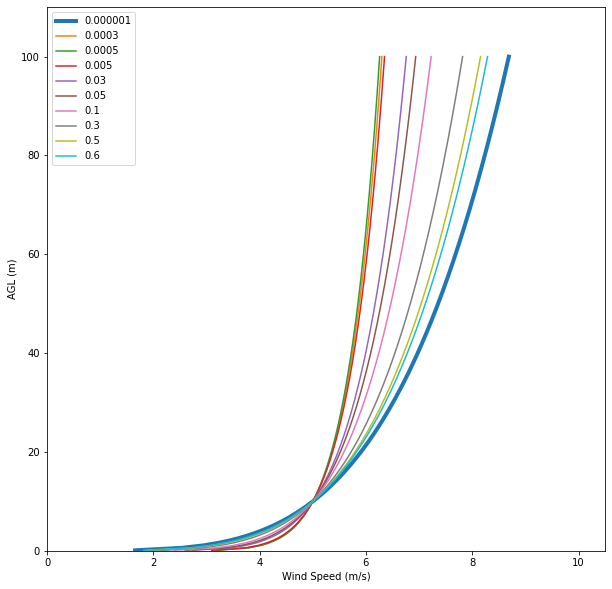

In [10]:
roughness_simulation(ls_emrn, h_range, path=constant.plot_path+"geoanalysis/roughness_simulation_pow.png")

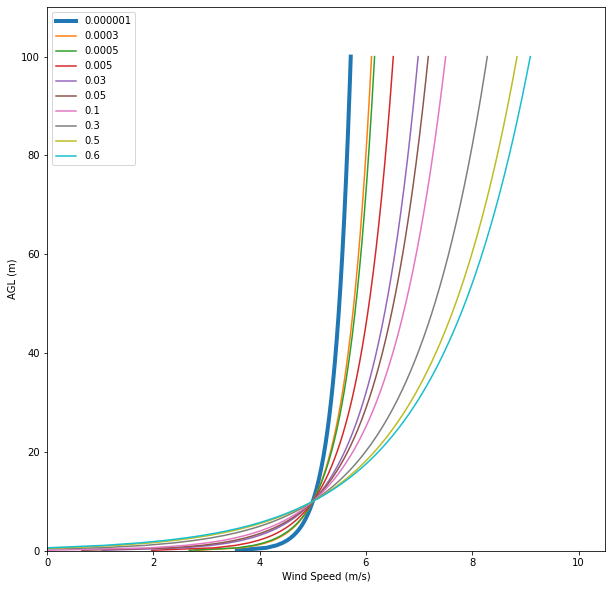

In [11]:
roughness_simulation(ls_smrn, h_range, path=constant.plot_path+"geoanalysis/roughness_simulation_log.png")

In [12]:
ls_smrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,3.57143,4.12699,4.315,4.43122,4.51558,4.58183,4.63639,4.68277,4.72311,4.75881,...,5.70002,5.70164,5.70325,5.70485,5.70644,5.70802,5.7096,5.71117,5.71273,5.71429
0.000300,2.78902,3.64886,3.93983,4.11971,4.25026,4.3528,4.43724,4.50903,4.57147,4.62671,...,6.08341,6.08591,6.0884,6.09088,6.09335,6.0958,6.09824,6.10067,6.10309,6.10549
0.000500,2.67498,3.57916,3.88515,4.07431,4.21159,4.31941,4.40821,4.48371,4.54936,4.60746,...,6.13929,6.14192,6.14454,6.14715,6.14974,6.15232,6.15489,6.15744,6.15998,6.16251
0.005000,1.97064,3.14874,3.54742,3.79388,3.97275,4.11324,4.22894,4.3273,4.41285,4.48854,...,6.48442,6.48785,6.49127,6.49466,6.49804,6.5014,6.50475,6.50807,6.51138,6.51468
0.030000,1.03627,2.57775,3.09939,3.42187,3.65591,3.83973,3.99112,4.11982,4.23175,4.33079,...,6.94227,6.94676,6.95123,6.95567,6.96009,6.96449,6.96887,6.97322,6.97755,6.98186
0.050000,0.65412,2.34421,2.91615,3.26972,3.52632,3.72786,3.89385,4.03495,4.15768,4.26627,...,7.12953,7.13446,7.13935,7.14422,7.14907,7.15389,7.15869,7.16347,7.16821,7.17294
0.100000,0,1.94447,2.60249,3.00928,3.30451,3.53639,3.72735,3.8897,4.0309,4.15583,...,7.45006,7.45572,7.46136,7.46696,7.47254,7.47809,7.48361,7.4891,7.49456,7.5
0.300000,-1.56651,0.98717,1.85135,2.38559,2.77331,3.07784,3.32863,3.54184,3.72728,3.89135,...,8.21767,8.22511,8.23251,8.23987,8.24719,8.25448,8.26173,8.26894,8.27612,8.28326
0.500000,-2.68622,0.30291,1.31445,1.93978,2.39362,2.75007,3.04363,3.2932,3.51026,3.70231,...,8.76634,8.77504,8.78371,8.79232,8.8009,8.80942,8.81791,8.82635,8.83475,8.84311
0.600000,-3.18432,-0.00148,1.07561,1.74147,2.22472,2.60427,2.91685,3.18259,3.41372,3.61821,...,9.01041,9.01968,9.02891,9.03808,9.04721,9.05629,9.06533,9.07432,9.08326,9.09216


In [13]:
ls_emrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,1.65566,2.54472,2.94313,3.22004,3.43719,3.61796,3.77395,3.91184,4.03586,4.14887,...,8.59361,8.60438,8.6151,8.62578,8.63642,8.64702,8.65758,8.66809,8.67857,8.689
0.000300,3.14935,3.76957,4.006,4.15952,4.27461,4.36723,4.44502,4.51224,4.57152,4.62463,...,6.27104,6.27432,6.27759,6.28084,6.28408,6.28731,6.29052,6.29371,6.29689,6.30006
0.000500,3.19205,3.80072,4.03195,4.18188,4.29418,4.38448,4.46028,4.52575,4.58347,4.63516,...,6.22979,6.23296,6.23611,6.23925,6.24237,6.24548,6.24857,6.25165,6.25472,6.25777
0.005000,3.09982,3.73322,3.97566,4.13335,4.25169,4.34701,4.42712,4.49638,4.5575,4.61227,...,6.31994,6.32337,6.32677,6.33016,6.33354,6.3369,6.34025,6.34358,6.34689,6.35019
0.030000,2.73621,3.45916,3.74478,3.93304,4.07556,4.19111,4.28873,4.37351,4.44861,4.51612,...,6.71839,6.72298,6.72755,6.7321,6.73662,6.74113,6.74562,6.75009,6.75454,6.75897
0.050000,2.59778,3.35113,3.65271,3.85257,4.00444,4.1279,4.23243,4.32338,4.40407,4.47671,...,6.8915,6.89661,6.9017,6.90677,6.91182,6.91684,6.92184,6.92682,6.93178,6.93672
0.100000,2.39315,3.18725,3.5118,3.72876,3.89456,4.02994,4.14496,4.24532,4.33459,4.41513,...,7.17421,7.1802,7.18616,7.1921,7.19801,7.2039,7.20976,7.2156,7.22141,7.2272
0.300000,2.04463,2.89497,3.25651,3.50226,3.69215,3.84848,3.98219,4.09951,4.20435,4.29935,...,7.74942,7.75727,7.76509,7.77288,7.78064,7.78836,7.79605,7.80371,7.81134,7.81894
0.500000,1.87875,2.74908,3.12704,3.38624,3.58772,3.75434,3.89735,4.0232,4.13596,4.23837,...,8.07746,8.08643,8.09535,8.10424,8.11309,8.12191,8.13069,8.13943,8.14815,8.15682
0.600000,1.81966,2.69592,3.07949,3.34344,3.54906,3.71938,3.86578,3.99475,4.11043,4.21556,...,8.20494,8.21434,8.2237,8.23303,8.24231,8.25156,8.26077,8.26995,8.27909,8.2882


In [29]:
ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)
def ws100_evaluation(df, ws_ass10, rn_range):
    ws100_rn = pd.DataFrame(columns=rn_range,index=['real','interp'])
    for rn in rn_range:
        if rn == 0.001:
            continue
        grid = windmills[windmills["Roughness"] == rn].head(1)["grid"].tolist()[0]
        index = ws10[ws10[grid] == ws_ass10].index[0]
        ws100_rn.loc['real'][rn] = ws100[[grid]].iloc[index][0]

    ws100_rn.loc["interp"] = df[100].T
    ws100_rn = ws100_rn.T
    ws100_rn["BIAS"] = ws100_rn["interp"] -  ws100_rn["real"]
    ws100_rn["AE"] = abs(ws100_rn["interp"] -  ws100_rn["real"])
    return ws100_rn

In [30]:
ls_smrn_evl = ws100_evaluation(ls_smrn, ws_ass10, rn_range)
ls_smrn_evl

,real,interp,BIAS,AE
0.000001,7.3,5.71429,-1.58571,1.58571
0.000300,6.5,6.10549,-0.39451,0.39451
0.000500,7.6,6.16251,-1.43749,1.43749
0.005000,8.7,6.51468,-2.18532,2.18532
0.030000,6.4,6.98186,0.58186,0.58186
0.050000,5.7,7.17294,1.47294,1.47294
0.100000,5.6,7.5,1.9,1.9
0.300000,8,8.28326,0.28326,0.28326
0.500000,7.5,8.84311,1.34311,1.34311
0.600000,10.3,9.09216,-1.20784,1.20784


In [44]:
for x in ls_smrn_evl['AE'].to_list():
    print(round(x,2)," & ")

1.59  & 
0.39  & 
1.44  & 
2.19  & 
0.58  & 
1.47  & 
1.9  & 
0.28  & 
1.34  & 
1.21  & 


In [ ]:
1.59  & 0.39  & 1.44  & 2.19  & 0.58  & 1.47  & 1.9  & 0.28  & 1.34  & 1.21

In [31]:
ls_smrn_evl["AE"].mean()

1.239204

In [32]:
ls_emrn_evl = ws100_evaluation(ls_emrn, ws_ass10, rn_range)
ls_emrn_evl

,real,interp,BIAS,AE
0.000001,7.3,8.689,1.389,1.389
0.000300,6.5,6.30006,-0.19994,0.19994
0.000500,7.6,6.25777,-1.34223,1.34223
0.005000,8.7,6.35019,-2.34981,2.34981
0.030000,6.4,6.75897,0.35897,0.35897
0.050000,5.7,6.93672,1.23672,1.23672
0.100000,5.6,7.2272,1.6272,1.6272
0.300000,8,7.81894,-0.18106,0.18106
0.500000,7.5,8.15682,0.65682,0.65682
0.600000,10.3,8.2882,-2.0118,2.0118


In [18]:
ls_emrn_evl["AE"].mean()

1.1353550000000001

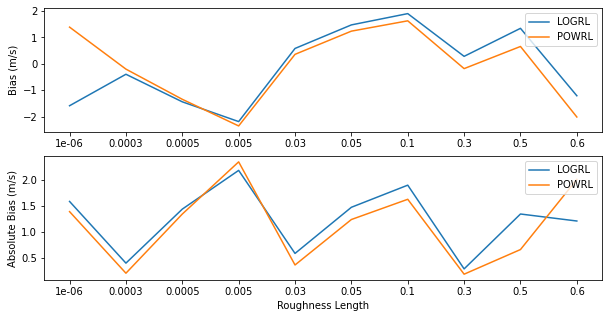

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10,5))
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)

x = np.linspace(0, 9, 10)
ax[0].plot(x, ls_smrn_evl["BIAS"], label="LOGRL")
ax[0].plot(x, ls_emrn_evl["BIAS"], label="POWRL")
ax[0].set_ylabel("Bias (m/s)")
ax[0].set_xticks(x)
ax[0].set_xticklabels(rn_range)

ax[1].plot(x, ls_smrn_evl["AE"], label="LOGRL")
ax[1].plot(x, ls_emrn_evl["AE"], label="POWRL")
ax[1].set_ylabel("Absolute Bias (m/s)")
ax[1].set_xticks(x)
ax[1].set_xticklabels(rn_range)

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
plt.xlabel("Roughness Length")
plt.show()

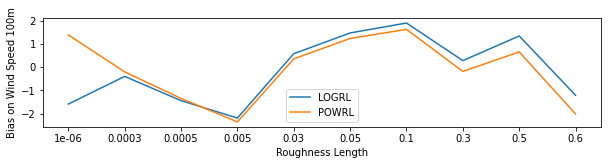

In [45]:
x = np.linspace(0, 9, 10)
plt.figure(figsize=(10,2))
plt.plot(x, ls_smrn_evl["BIAS"], label="LOGRL")
plt.plot(x, ls_emrn_evl["BIAS"], label="POWRL")
plt.xticks(x, labels=rn_range)
plt.xlabel("Roughness Length")
plt.ylabel("Bias on Wind Speed 100m")
plt.legend()

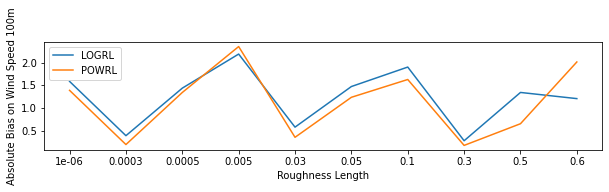

In [46]:
x = np.linspace(0,9, 10)
plt.figure(figsize=(10,2))
plt.plot(x, ls_smrn_evl["AE"], label="LOGRL")
plt.plot(x, ls_emrn_evl["AE"], label="POWRL")
plt.xticks(x, labels=rn_range)
plt.xlabel("Roughness Length")
plt.ylabel("Absolute Bias on Wind Speed 100m")
plt.legend()